
# Import packages

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import scipy.stats as st
import random
import matplotlib.pyplot as plt

# Import the data for each timepoint

In [2]:
file_paths = sorted(glob.glob('./rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_*'))
file_paths

['./rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_000min_A',
 './rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_000min_B',
 './rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_030min_A',
 './rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_030min_B',
 './rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_060min_A',
 './rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_060min_B',
 './rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_090min_A',
 './rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_090min_B',
 './rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_120min_A',
 './rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_120min_B',
 './rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_150min_A',
 './rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_150min_B',
 './rna_seq_count_data/kallisto_quant_2024/kallisto_

In [3]:
dict_samtools_tpms = {}

for fp in file_paths:
    split = ((os.path.splitext(os.path.basename(fp))[0]).split('_'))
    key = '_'.join(split[len(split)-2:len(split)])
    print(key)
    dict_samtools_tpms[key] = (pd.read_csv(os.path.join(fp, 'abundance.tsv'), delimiter='\t'))

print(np.unique([df.shape for df in dict_samtools_tpms.values()]))

000min_A
000min_B
030min_A
030min_B
060min_A
060min_B
090min_A
090min_B
120min_A
120min_B
150min_A
150min_B
180min_A
180min_B
210min_A
210min_B
240min_A
240min_B
[    5 25987]


In [4]:
dict_samtools_tpms['000min_A'].head()

,target_id,length,eff_length,est_counts,tpm
0,YF00013476.t1,7212,7022.640,757.0,1.229920
1,YF00013477.t1,2502,2312.640,273.0,1.346900
2,YF00036562.t1,4962,4772.640,14.0,0.033469
3,YF00036564.t1,6309,6119.640,630.0,1.174610
4,YF00013481.t1,966,776.636,6533.0,95.978700


In [5]:
def computeRPK(row):
    if not row['eff_length'] > 0:
        print('ZERO sequence length:', row['target_id'])
        print(row)
        return 'ZERO sequence length'
    return row['est_counts']/row['eff_length']

def computeTPM(row, normalization_factor):
    return row['rpk']/normalization_factor

def compute_tpm_columns(df_dict):
    df_tpm = {}
    normalization_factor_dict = {}
    for key, df in df_dict.items():
        tpm_df = df
        tpm_df['rpk'] = tpm_df.apply(computeRPK, axis=1)
        tpm_df = tpm_df.loc[tpm_df['rpk']!='ZERO sequence length']

        sum_rpk = tpm_df['rpk'].sum()

        normalization_factor = sum_rpk/1_000_000

        tpm_df['tpm_manual'] = tpm_df.apply(computeTPM, axis=1, args=(normalization_factor,))

        df_tpm[key] = tpm_df  
        normalization_factor_dict[key] = normalization_factor

    return df_tpm, normalization_factor_dict

In [6]:
dict_samtools_tpms, norm_factors_dict = compute_tpm_columns(dict_samtools_tpms)

In [7]:
dict_samtools_tpms['150min_A'].head()

,target_id,length,eff_length,est_counts,tpm,rpk,tpm_manual
0,YF00013476.t1,7212,7025.980,764.0,1.43456,0.108739,1.434564
1,YF00013477.t1,2502,2315.980,2592.0,14.76500,1.119181,14.765009
2,YF00036562.t1,4962,4775.980,699.0,1.93085,0.146357,1.930849
3,YF00036564.t1,6309,6122.980,482.0,1.03853,0.078720,1.038527
4,YF00013481.t1,966,779.979,2761.0,46.70000,3.539839,46.700015


In [8]:
norm_factors_dict

{'000min_A': 0.08764359044702891,
 '000min_B': 0.10142149887215271,
 '030min_A': 0.09224228585052313,
 '030min_B': 0.08971928915246696,
 '060min_A': 0.08689457031699578,
 '060min_B': 0.110510607854403,
 '090min_A': 0.07984283822670517,
 '090min_B': 0.09409812434010506,
 '120min_A': 0.08049852282663537,
 '120min_B': 0.10143849606041971,
 '150min_A': 0.07579952343144356,
 '150min_B': 0.09527650682639892,
 '180min_A': 0.09132111691134094,
 '180min_B': 0.0917491736119316,
 '210min_A': 0.06972040366687281,
 '210min_B': 0.08735273419185882,
 '240min_A': 0.10089281480313546,
 '240min_B': 0.09428391975618013}

In [9]:
ttherm_id = 'TTHERM_01528510'

dict_samtools_tpms['000min_A'].loc[dict_samtools_tpms['000min_A']['target_id'] == ttherm_id]

,target_id,length,eff_length,est_counts,tpm,rpk,tpm_manual


In [10]:
dict_samtools_tpms['000min_A'].shape

(25987, 7)

## Checkout a single timepoint

In [11]:
num_nonzero = (dict_samtools_tpms['000min_A'].loc[dict_samtools_tpms['000min_A']['tpm'] != 0.0].shape)[0]

mean = dict_samtools_tpms['000min_A']['tpm'].mean()

std = dict_samtools_tpms['000min_A']['tpm'].std()

str_summary_wzeros = f'''WITH ZEROS...
MEAN: {mean}
MEDIAN: {dict_samtools_tpms['000min_A']['tpm'].median()}
STDEV: {std}
CV: {(std/mean)*100}
MAX: {dict_samtools_tpms['000min_A']['tpm'].max()}
MIN: {dict_samtools_tpms['000min_A']['tpm'].min()}
# GENES EXPRESSED: {num_nonzero}
'''

df_tpm_wozeros = dict_samtools_tpms['000min_A'].loc[dict_samtools_tpms['000min_A']['tpm'] != 0.0]

mean_wozeros = df_tpm_wozeros['tpm'].mean()

std_wozeros = df_tpm_wozeros['tpm'].std()

str_summary_wozeros = f'''WITHOUT ZEROS...
MEAN: {mean_wozeros}
MEDIAN: {df_tpm_wozeros['tpm'].median()}
STDEV: {std_wozeros}
CV: {(std_wozeros/mean_wozeros)*100}
MAX: {df_tpm_wozeros['tpm'].max()}
MIN: {df_tpm_wozeros['tpm'].min()}
# GENES EXPRESSED: {num_nonzero}
'''

print(str_summary_wzeros, '\n', str_summary_wozeros, sep='')


WITH ZEROS...
MEAN: 38.48077988601189
MEDIAN: 0.937477
STDEV: 380.2093962449458
CV: 988.0501314453749
MAX: 24066.6
MIN: 0.0
# GENES EXPRESSED: 22592

WITHOUT ZEROS...
MEAN: 44.26345728124074
MEDIAN: 1.4707050000000002
STDEV: 407.46499676954954
CV: 920.5448959411424
MAX: 24066.6
MIN: 7.03107e-11
# GENES EXPRESSED: 22592



# Create a dataframe containing all TPM data at every timepoint (sorted by TTHERM_ID)

In [12]:
columns = sorted(list(dict_samtools_tpms.keys()))
columns

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [13]:
curr_df = dict_samtools_tpms['000min_A'].sort_values(by='target_id')
dict_df_all_tpm = {'TTHERM_ID': curr_df['target_id'].values}
print(curr_df.head(3))

for col in columns:
    curr_df = dict_samtools_tpms[col].sort_values(by='target_id')
    print(curr_df.head(3))
    dict_df_all_tpm[col] = (curr_df)['tpm'].values

df_all_tpm = pd.DataFrame(dict_df_all_tpm)

print(df_all_tpm.shape)

df_all_tpm.head()

           target_id  length  eff_length  est_counts        tpm       rpk  \
20015  YF00000001.t1     420     233.375        12.0   0.586688  0.051419   
20016  YF00000003.t1    4356    4166.640     11089.0  30.365900  2.661377   
20017  YF00000004.t1    1200    1010.640       102.0   1.151560  0.100926   

       tpm_manual  
20015    0.586687  
20016   30.365906  
20017    1.151552  
           target_id  length  eff_length  est_counts        tpm       rpk  \
20015  YF00000001.t1     420     233.375        12.0   0.586688  0.051419   
20016  YF00000003.t1    4356    4166.640     11089.0  30.365900  2.661377   
20017  YF00000004.t1    1200    1010.640       102.0   1.151560  0.100926   

       tpm_manual  
20015    0.586687  
20016   30.365906  
20017    1.151552  
           target_id  length  eff_length  est_counts       tpm       rpk  \
20015  YF00000001.t1     420     235.226        40.0   1.67666  0.170049   
20016  YF00000003.t1    4356    4168.770     13722.0  32.45480  3.2916

           target_id  length  eff_length  est_counts       tpm       rpk  \
20015  YF00000001.t1     420     227.836        22.0   1.10541  0.096561   
20016  YF00000003.t1    4356    4158.560     17741.0  48.83810  4.266140   
20017  YF00000004.t1    1200    1002.560      1378.0  15.73490  1.374481   

       tpm_manual  
20015    1.105411  
20016   48.838084  
20017   15.734840  
           target_id  length  eff_length  est_counts        tpm       rpk  \
20015  YF00000001.t1     420     229.614        11.0   0.474825  0.047906   
20016  YF00000003.t1    4356    4162.680     15251.0  36.313300  3.663745   
20017  YF00000004.t1    1200    1006.680      1409.0  13.872700  1.399650   

       tpm_manual  
20015    0.474826  
20016   36.313245  
20017   13.872646  
           target_id  length  eff_length  est_counts       tpm       rpk  \
20015  YF00000001.t1     420     231.934        22.0   1.00605  0.094855   
20016  YF00000003.t1    4356    4165.140     16559.0  42.16640  3.975617  

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,YF00000001.t1,0.586688,1.67666,0.941571,1.43078,0.39673,1.37467,0.642154,1.55882,1.16155,1.87789,0.556894,1.46126,0.714378,1.93705,0.250387,1.10541,0.474825,1.00605
1,YF00000003.t1,30.365900,32.45480,43.555100,29.39020,48.14460,30.63640,59.071300,31.16230,52.88810,38.39890,47.206000,36.22920,51.271300,43.32920,46.160600,48.83810,36.313300,42.16640
2,YF00000004.t1,1.151560,2.62859,24.640100,26.66560,43.23010,19.20550,40.661300,25.40090,24.48950,24.96380,14.598100,18.05180,11.361800,16.56940,9.478250,15.73490,13.872700,13.17980
3,YF00000005.t1,33.436500,96.28970,60.380000,99.78100,66.93020,104.45600,63.086300,97.37460,59.34830,106.06300,53.745700,124.78900,55.339100,89.40470,55.587700,67.44460,48.414400,65.32540
4,YF00000006.t1,16.980400,10.33890,14.464300,14.76590,24.43420,14.55810,24.204800,14.89720,23.90960,17.97100,23.469000,15.33890,25.727200,19.34310,23.332400,21.26720,18.955400,20.28760


In [14]:
all_cols = list(df_all_tpm.columns)
all_cols

['TTHERM_ID',
 '000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

## Check out genes with all zeros

In [15]:
rows_with_all_zeros = df_all_tpm[(df_all_tpm.iloc[:, 1:] == 0.0).all(axis=1)]

print(rows_with_all_zeros.shape)

rows_with_all_zeros.head()

(1339, 19)


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
15,YF00000019.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,YF00000082.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,YF00000084.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95,YF00000119.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,YF00000123.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Check out rows with one nonzero

In [16]:
rows_with_one_nonzero = df_all_tpm[(df_all_tpm.iloc[:, 1:] == 0.0).sum(axis=1) == 17]

print(rows_with_one_nonzero.shape)

rows_with_one_nonzero.head()

(480, 19)


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
68,YF00000081.t1,0.0,0.000000,0.0,0.036996,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
169,YF00000208.t1,0.0,0.051487,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
181,YF00000224.t1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.044273,0.0
217,YF00000266.t1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.083607,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
293,YF00000364.t1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.028285,0.0


## Check out the distribution of the number of zeros

In [17]:
num_zeros_counts = {}

for i in range(20):
    num_zeros = (df_all_tpm.iloc[:, 1:] == 0.0).sum(axis=1)
    
    rows_with_num_zeros = df_all_tpm[num_zeros == i]
    
    num_zeros_counts[i] = len(rows_with_num_zeros)

for num_zeros, count in num_zeros_counts.items():
    print(f"Number of rows with {num_zeros} zeros: {count}")

Number of rows with 0 zeros: 19964
Number of rows with 1 zeros: 569
Number of rows with 2 zeros: 371
Number of rows with 3 zeros: 322
Number of rows with 4 zeros: 244
Number of rows with 5 zeros: 231
Number of rows with 6 zeros: 236
Number of rows with 7 zeros: 220
Number of rows with 8 zeros: 204
Number of rows with 9 zeros: 194
Number of rows with 10 zeros: 202
Number of rows with 11 zeros: 198
Number of rows with 12 zeros: 187
Number of rows with 13 zeros: 212
Number of rows with 14 zeros: 216
Number of rows with 15 zeros: 277
Number of rows with 16 zeros: 321
Number of rows with 17 zeros: 480
Number of rows with 18 zeros: 1339
Number of rows with 19 zeros: 0


## Filter out genes with all zeros

In [18]:
df_no_all_zeros = df_all_tpm[~df_all_tpm.isin(rows_with_all_zeros)].dropna()
df_no_all_zeros.reset_index()
print(df_all_tpm.shape[0]-df_no_all_zeros.shape[0])
df_no_all_zeros.head()

1339


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,YF00000001.t1,0.586688,1.67666,0.941571,1.43078,0.39673,1.37467,0.642154,1.55882,1.16155,1.87789,0.556894,1.46126,0.714378,1.93705,0.250387,1.10541,0.474825,1.00605
1,YF00000003.t1,30.365900,32.45480,43.555100,29.39020,48.14460,30.63640,59.071300,31.16230,52.88810,38.39890,47.206000,36.22920,51.271300,43.32920,46.160600,48.83810,36.313300,42.16640
2,YF00000004.t1,1.151560,2.62859,24.640100,26.66560,43.23010,19.20550,40.661300,25.40090,24.48950,24.96380,14.598100,18.05180,11.361800,16.56940,9.478250,15.73490,13.872700,13.17980
3,YF00000005.t1,33.436500,96.28970,60.380000,99.78100,66.93020,104.45600,63.086300,97.37460,59.34830,106.06300,53.745700,124.78900,55.339100,89.40470,55.587700,67.44460,48.414400,65.32540
4,YF00000006.t1,16.980400,10.33890,14.464300,14.76590,24.43420,14.55810,24.204800,14.89720,23.90960,17.97100,23.469000,15.33890,25.727200,19.34310,23.332400,21.26720,18.955400,20.28760


In [19]:
df_no_all_zeros.shape

(24648, 19)

## Check out the genes which display the highest expression

In [20]:
df_no_all_zeros.loc[:, df_no_all_zeros.columns[1:]].max(axis=None)

56844.4

In [21]:
max_tpm_ttherms = []

for col in df_no_all_zeros.columns[1:]:
    max_tpm = df_no_all_zeros[col].max()
    max_tpm_ttherm = df_no_all_zeros['TTHERM_ID'].loc[df_no_all_zeros[col] == df_no_all_zeros[col].max()].values[0]
    print(col, 'MAX:', max_tpm, '|', max_tpm_ttherm)
    max_tpm_ttherms.append(max_tpm_ttherm)
    

000min_A MAX: 24066.6 | YF00003862.t1
000min_B MAX: 50334.6 | YF00003862.t1
030min_A MAX: 36006.6 | YF00016492.t1
030min_B MAX: 53698.0 | YF00016492.t1
060min_A MAX: 25488.8 | YF00016492.t1
060min_B MAX: 52352.1 | YF00016492.t1
090min_A MAX: 29475.1 | YF00003862.t1
090min_B MAX: 49362.8 | YF00003862.t1
120min_A MAX: 30933.5 | YF00003862.t1
120min_B MAX: 51420.7 | YF00003862.t1
150min_A MAX: 27235.0 | YF00003862.t1
150min_B MAX: 56844.4 | YF00003862.t1
180min_A MAX: 25523.5 | YF00003862.t1
180min_B MAX: 40729.6 | YF00003862.t1
210min_A MAX: 23139.8 | YF00003862.t1
210min_B MAX: 29244.5 | YF00003862.t1
240min_A MAX: 25990.6 | YF00003862.t1
240min_B MAX: 31894.7 | YF00003862.t1


In [22]:
np.unique(max_tpm_ttherms)

array(['YF00003862.t1', 'YF00016492.t1'], dtype='<U13')

Identifier	Gene Name	Alias Name(s)	Description
TTHERM_00105330	RPS28	7.m00482, PreTt23033	RPS28 40S ribosomal protein S28e putative; Homolog of yeast RPS28- human RPS28;

Identifier	Gene Name	Alias Name(s)	Description
TTHERM_00682940		103.m00122, 3734.m00034, PreTt16131	60S ribosomal protein L29

In [23]:
df_no_all_zeros_cols = df_no_all_zeros.columns[1:]
df_no_all_zeros_cols

Index(['000min_A', '000min_B', '030min_A', '030min_B', '060min_A', '060min_B',
       '090min_A', '090min_B', '120min_A', '120min_B', '150min_A', '150min_B',
       '180min_A', '180min_B', '210min_A', '210min_B', '240min_A', '240min_B'],
      dtype='object')

In [24]:
df_no_all_zeros_cols_a = [col for col in df_no_all_zeros_cols if 'A' in col]
df_no_all_zeros_cols_a

['000min_A',
 '030min_A',
 '060min_A',
 '090min_A',
 '120min_A',
 '150min_A',
 '180min_A',
 '210min_A',
 '240min_A']

## Compute the TPM differences between duplicates

In [25]:
for col_a in df_no_all_zeros_cols_a:

    col_b = col_a.replace('A', 'B')

    df_no_all_zeros[f'{col_a.replace("_A", "")}_diff'] = (df_no_all_zeros[col_a] - df_no_all_zeros[col_b]).abs()

In [26]:
df_no_all_zeros.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,240min_B,000min_diff,030min_diff,060min_diff,090min_diff,120min_diff,150min_diff,180min_diff,210min_diff,240min_diff
0,YF00000001.t1,0.586688,1.67666,0.941571,1.43078,0.39673,1.37467,0.642154,1.55882,1.16155,...,1.00605,1.089972,0.489209,0.97794,0.916666,0.71634,0.904366,1.222672,0.855023,0.531225
1,YF00000003.t1,30.365900,32.45480,43.555100,29.39020,48.14460,30.63640,59.071300,31.16230,52.88810,...,42.16640,2.088900,14.164900,17.50820,27.909000,14.48920,10.976800,7.942100,2.677500,5.853100
2,YF00000004.t1,1.151560,2.62859,24.640100,26.66560,43.23010,19.20550,40.661300,25.40090,24.48950,...,13.17980,1.477030,2.025500,24.02460,15.260400,0.47430,3.453700,5.207600,6.256650,0.692900
3,YF00000005.t1,33.436500,96.28970,60.380000,99.78100,66.93020,104.45600,63.086300,97.37460,59.34830,...,65.32540,62.853200,39.401000,37.52580,34.288300,46.71470,71.043300,34.065600,11.856900,16.911000
4,YF00000006.t1,16.980400,10.33890,14.464300,14.76590,24.43420,14.55810,24.204800,14.89720,23.90960,...,20.28760,6.641500,0.301600,9.87610,9.307600,5.93860,8.130100,6.384100,2.065200,1.332200


### Sanity check

In [27]:
[(str(num)).zfill(3) for num in np.arange(0, 241, 30)]

['000', '030', '060', '090', '120', '150', '180', '210', '240']

In [28]:
random_ttherms = [random.choice(df_no_all_zeros['TTHERM_ID'].values) for _ in range(10)]
random_time = random.choice([f'{((str(num)).zfill(3))}min' for num in np.arange(0, 241, 30)])

print('TIME:', random_time)

for ttherm in random_ttherms:
    val_a = df_no_all_zeros[f'{random_time}_A'].loc[df_no_all_zeros['TTHERM_ID'] == ttherm].values[0]
    val_b = df_no_all_zeros[f'{random_time}_B'].loc[df_no_all_zeros['TTHERM_ID'] == ttherm].values[0]
    val_diff = df_no_all_zeros[f'{random_time}_diff'].loc[df_no_all_zeros['TTHERM_ID'] == ttherm].values[0]
    print(ttherm, f'|{val_a}-{val_b}| = {val_diff} -> {np.abs(val_a - val_b) == val_diff}', sep=' | ')

TIME: 120min
YF00012205.t1 | |0.0-0.0609292| = 0.0609292 -> True
YF00022805.t1 | |59.6397-48.3692| = 11.270499999999998 -> True
YF00007026.t1 | |5.28723-4.15609| = 1.1311400000000003 -> True
YF00025074.t1 | |80.5792-51.2884| = 29.290799999999997 -> True
YF00009397.t1 | |11.2611-15.2455| = 3.984399999999999 -> True
YF00030444.t1 | |0.270773-0.284263| = 0.013490000000000002 -> True
YF00014632.t1 | |13.1696-32.4866| = 19.317 -> True
YF00008331.t1 | |14.1019-13.2017| = 0.9001999999999999 -> True
YF00027571.t1 | |11.8482-10.0696| = 1.7786000000000008 -> True
YF00021589.t1 | |0.00502685-0.0| = 0.00502685 -> True


## Compute the differences between TPM and ∆TPM for the two repeated cycles

In [29]:
df_no_all_zeros.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,240min_B,000min_diff,030min_diff,060min_diff,090min_diff,120min_diff,150min_diff,180min_diff,210min_diff,240min_diff
0,YF00000001.t1,0.586688,1.67666,0.941571,1.43078,0.39673,1.37467,0.642154,1.55882,1.16155,...,1.00605,1.089972,0.489209,0.97794,0.916666,0.71634,0.904366,1.222672,0.855023,0.531225
1,YF00000003.t1,30.365900,32.45480,43.555100,29.39020,48.14460,30.63640,59.071300,31.16230,52.88810,...,42.16640,2.088900,14.164900,17.50820,27.909000,14.48920,10.976800,7.942100,2.677500,5.853100
2,YF00000004.t1,1.151560,2.62859,24.640100,26.66560,43.23010,19.20550,40.661300,25.40090,24.48950,...,13.17980,1.477030,2.025500,24.02460,15.260400,0.47430,3.453700,5.207600,6.256650,0.692900
3,YF00000005.t1,33.436500,96.28970,60.380000,99.78100,66.93020,104.45600,63.086300,97.37460,59.34830,...,65.32540,62.853200,39.401000,37.52580,34.288300,46.71470,71.043300,34.065600,11.856900,16.911000
4,YF00000006.t1,16.980400,10.33890,14.464300,14.76590,24.43420,14.55810,24.204800,14.89720,23.90960,...,20.28760,6.641500,0.301600,9.87610,9.307600,5.93860,8.130100,6.384100,2.065200,1.332200


In [30]:
percent_diff_col_pairs = [['000min_A', '210min_A'], ['000min_B', '210min_B'], ['000min_diff', '210min_diff'], ['030min_A', '240min_A'], ['030min_B', '240min_B'], ['030min_diff', '240min_diff']]
print_cols = []

for pair in percent_diff_col_pairs:
    col_1 = pair[0]
    col_2 = pair[1]
    new_col_name = f'percent_diff_{col_1}_{col_2}'
    df_no_all_zeros[new_col_name] = np.nan_to_num(100 * (np.absolute(df_no_all_zeros[col_1] - df_no_all_zeros[col_2])/((df_no_all_zeros[col_1] + df_no_all_zeros[col_2]) / 2)), nan=0)
    print_cols.append(new_col_name)

df_no_all_zeros.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,150min_diff,180min_diff,210min_diff,240min_diff,percent_diff_000min_A_210min_A,percent_diff_000min_B_210min_B,percent_diff_000min_diff_210min_diff,percent_diff_030min_A_240min_A,percent_diff_030min_B_240min_B,percent_diff_030min_diff_240min_diff
0,YF00000001.t1,0.586688,1.67666,0.941571,1.43078,0.39673,1.37467,0.642154,1.55882,1.16155,...,0.904366,1.222672,0.855023,0.531225,80.351462,41.066544,24.159342,65.906145,34.859223,8.234927
1,YF00000003.t1,30.365900,32.45480,43.555100,29.39020,48.14460,30.63640,59.071300,31.16230,52.88810,...,10.976800,7.942100,2.677500,5.853100,41.279034,40.306841,24.697885,18.134331,35.709355,83.043261
2,YF00000004.t1,1.151560,2.62859,24.640100,26.66560,43.23010,19.20550,40.661300,25.40090,24.48950,...,3.453700,5.207600,6.256650,0.692900,156.666770,142.743128,123.605321,55.915955,67.690624,98.042966
3,YF00000005.t1,33.436500,96.28970,60.380000,99.78100,66.93020,104.45600,63.086300,97.37460,59.34830,...,71.043300,34.065600,11.856900,16.911000,49.764446,35.234035,136.517820,21.996720,41.737449,79.876403
4,YF00000006.t1,16.980400,10.33890,14.464300,14.76590,24.43420,14.55810,24.204800,14.89720,23.90960,...,8.130100,6.384100,2.065200,1.332200,31.513564,69.153107,105.121343,26.876962,31.504415,126.159873


In [31]:
print_cols_padding = max([len(col) for col in print_cols])

for col in print_cols:
    print(f'{" "*(print_cols_padding-len(col))}{col}:', df_no_all_zeros[col].mean())

      percent_diff_000min_A_210min_A: 59.11356903632433
      percent_diff_000min_B_210min_B: 61.73439886489784
percent_diff_000min_diff_210min_diff: 108.72107422535933
      percent_diff_030min_A_240min_A: 47.88076125829554
      percent_diff_030min_B_240min_B: 49.5260898592382
percent_diff_030min_diff_240min_diff: 102.05575051280002


In [32]:
print_cols_padding = max([len(col) for col in print_cols])

for col in print_cols:
    print(f'{" "*(print_cols_padding-len(col))}{col}:', df_no_all_zeros[col].median())

      percent_diff_000min_A_210min_A: 40.89135867696572
      percent_diff_000min_B_210min_B: 46.728151145794094
percent_diff_000min_diff_210min_diff: 113.30170912077716
      percent_diff_030min_A_240min_A: 31.784761067668946
      percent_diff_030min_B_240min_B: 34.253135067630836
percent_diff_030min_diff_240min_diff: 103.63993444660005


In [33]:
print_cols_padding = max([len(col) for col in print_cols])

for col in print_cols:
    print(f'{" "*(print_cols_padding-len(col))}{col}:', df_no_all_zeros[col].std())

      percent_diff_000min_A_210min_A: 57.13897201004343
      percent_diff_000min_B_210min_B: 55.06584335965166
percent_diff_000min_diff_210min_diff: 61.74043946856604
      percent_diff_030min_A_240min_A: 51.161114073388234
      percent_diff_030min_B_240min_B: 50.831290618236764
percent_diff_030min_diff_240min_diff: 62.154822146797066


## Take a look at the distribution of differences

In [34]:

diff_cols = [col for col in list(df_no_all_zeros.columns) if 'diff' in col]
diff_cols

['000min_diff',
 '030min_diff',
 '060min_diff',
 '090min_diff',
 '120min_diff',
 '150min_diff',
 '180min_diff',
 '210min_diff',
 '240min_diff',
 'percent_diff_000min_A_210min_A',
 'percent_diff_000min_B_210min_B',
 'percent_diff_000min_diff_210min_diff',
 'percent_diff_030min_A_240min_A',
 'percent_diff_030min_B_240min_B',
 'percent_diff_030min_diff_240min_diff']

In [35]:
diffs_flattened = df_no_all_zeros.loc[:, diff_cols].to_numpy().flatten()
diffs_flattened.shape, diffs_flattened

((369720,),
 array([1.089972, 0.489209, 0.97794 , ..., 0.      , 0.      , 0.      ]))

In [36]:
st.percentileofscore(diffs_flattened, 0)

2.8376879800930435

In [37]:
sorted(diffs_flattened, reverse=True)

[29816.8,
 29609.4,
 26863.3,
 26268.0,
 23589.500000000004,
 23311.42,
 20954.64,
 20487.199999999997,
 19887.700000000004,
 19316.5,
 17691.4,
 15206.099999999999,
 14339.3,
 10661.62,
 9205.599999999999,
 8759.18,
 7892.620000000001,
 6980.43,
 6407.800000000001,
 6346.32,
 6104.700000000001,
 5973.800000000001,
 5904.100000000002,
 5568.6,
 5336.29,
 5192.299999999999,
 5163.330000000001,
 5024.4,
 4693.98,
 4621.85,
 4612.379999999999,
 4549.66,
 4472.339999999999,
 4303.820000000001,
 4185.03,
 4087.1900000000005,
 4066.4900000000016,
 4004.0899999999997,
 3911.659999999999,
 3905.98,
 3828.1100000000006,
 3764.69,
 3750.34,
 3683.28,
 3665.19,
 3633.6399999999994,
 3550.7400000000002,
 3549.790000000001,
 3535.47,
 3512.043,
 3501.8999999999996,
 3430.0299999999997,
 3388.97,
 3341.8999999999996,
 3282.6679999999997,
 3262.4100000000003,
 3231.28,
 3218.33,
 3199.62,
 3196.1399999999994,
 3180.7000000000007,
 3163.5739999999996,
 3081.1100000000006,
 3051.92,
 3027.91,
 3019.200

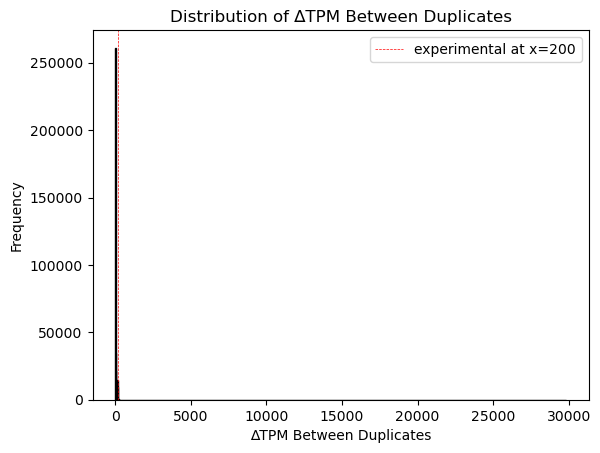

In [38]:
plt.hist(diffs_flattened, bins=1000, edgecolor='black')

line_num = 200

plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))

plt.xlabel('∆TPM Between Duplicates')
plt.ylabel('Frequency')
plt.title(f'Distribution of ∆TPM Between Duplicates')

plt.legend()

plt.show()

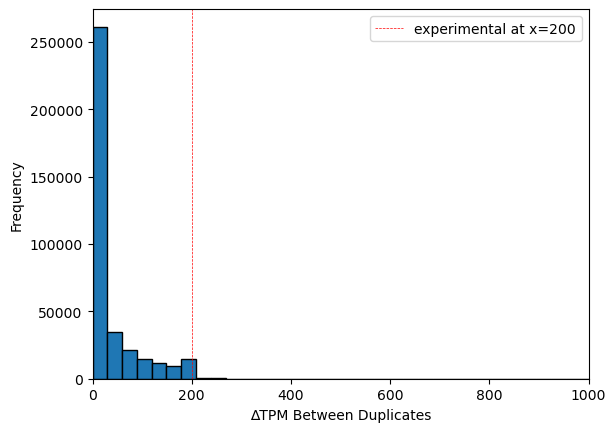

In [39]:
plt.hist(diffs_flattened, bins=1000, edgecolor='black')

line_num = 200

plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))

plt.xlabel('∆TPM Between Duplicates')
plt.ylabel('Frequency')
plt.title(f'')

plt.legend()

plt.xlim(0, 1000)

plt.show()

In [40]:
tpm_cols = [col for col in df_no_all_zeros.columns[1:] if 'diff' not in col]
tpm_cols

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [41]:
tpms_flattened = df_no_all_zeros[tpm_cols].to_numpy().flatten()
tpms_flattened.shape, tpms_flattened

((443664,),
 array([0.586688, 1.67666 , 0.941571, ..., 0.      , 0.      , 0.      ]))

## Take a look at the distribution of TPMs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


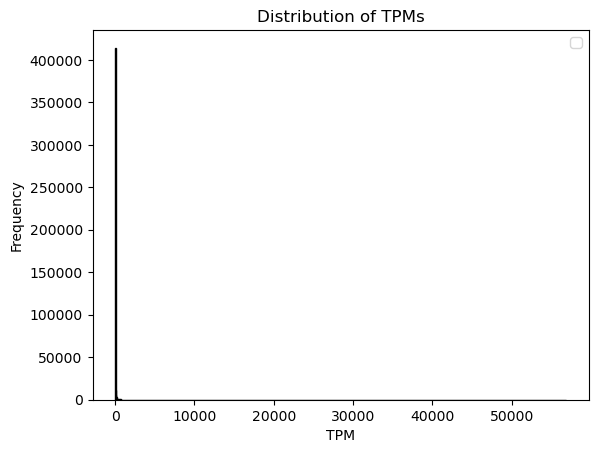

In [42]:
plt.hist(tpms_flattened, bins=1000, edgecolor='black')

line_num = 200

# plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))

plt.xlabel('TPM')
plt.ylabel('Frequency')
plt.title(f'Distribution of TPMs')

plt.legend()

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


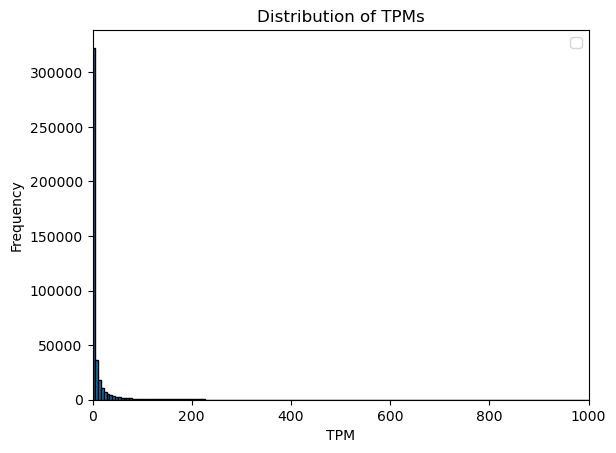

In [43]:
plt.hist(tpms_flattened, bins=10000, edgecolor='black')

line_num = 200

# plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))

plt.xlabel('TPM')
plt.ylabel('Frequency')
plt.title(f'Distribution of TPMs')

plt.legend()

plt.xlim(0, 1000)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


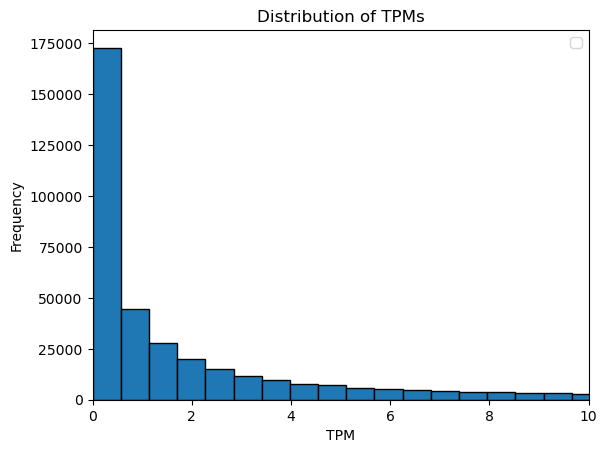

In [44]:
plt.hist(tpms_flattened, bins=100000, edgecolor='black')

line_num = 200

# plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))

plt.xlabel('TPM')
plt.ylabel('Frequency')
plt.title(f'Distribution of TPMs')

plt.legend()

plt.xlim(0, 10)

plt.show()

In [45]:
sorted(tpms_flattened)

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

Filter genes that have a max TPM value in the bottom 10% of all TPM values

In [46]:
np.percentile(tpms_flattened, 5)

0.0

In [47]:
st.percentileofscore(tpms_flattened, 0)

4.554798225684301

In [48]:
np.count_nonzero(tpms_flattened)/len(tpms_flattened)

0.9089062894442641

In [49]:
1 - np.count_nonzero(tpms_flattened)/len(tpms_flattened)

0.0910937105557359

In [50]:
np.percentile(tpms_flattened, 10)

0.00575609

In [51]:
df_no_all_zeros['max_tpm'] = df_no_all_zeros[tpm_cols].apply(lambda x: max(x), axis=1)
df_no_all_zeros.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,180min_diff,210min_diff,240min_diff,percent_diff_000min_A_210min_A,percent_diff_000min_B_210min_B,percent_diff_000min_diff_210min_diff,percent_diff_030min_A_240min_A,percent_diff_030min_B_240min_B,percent_diff_030min_diff_240min_diff,max_tpm
0,YF00000001.t1,0.586688,1.67666,0.941571,1.43078,0.39673,1.37467,0.642154,1.55882,1.16155,...,1.222672,0.855023,0.531225,80.351462,41.066544,24.159342,65.906145,34.859223,8.234927,1.93705
1,YF00000003.t1,30.365900,32.45480,43.555100,29.39020,48.14460,30.63640,59.071300,31.16230,52.88810,...,7.942100,2.677500,5.853100,41.279034,40.306841,24.697885,18.134331,35.709355,83.043261,59.07130
2,YF00000004.t1,1.151560,2.62859,24.640100,26.66560,43.23010,19.20550,40.661300,25.40090,24.48950,...,5.207600,6.256650,0.692900,156.666770,142.743128,123.605321,55.915955,67.690624,98.042966,43.23010
3,YF00000005.t1,33.436500,96.28970,60.380000,99.78100,66.93020,104.45600,63.086300,97.37460,59.34830,...,34.065600,11.856900,16.911000,49.764446,35.234035,136.517820,21.996720,41.737449,79.876403,124.78900
4,YF00000006.t1,16.980400,10.33890,14.464300,14.76590,24.43420,14.55810,24.204800,14.89720,23.90960,...,6.384100,2.065200,1.332200,31.513564,69.153107,105.121343,26.876962,31.504415,126.159873,25.72720


In [52]:
df_no_all_zeros['max_diff'] = df_no_all_zeros[diff_cols].apply(lambda x: max(x), axis=1)
df_no_all_zeros.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,210min_diff,240min_diff,percent_diff_000min_A_210min_A,percent_diff_000min_B_210min_B,percent_diff_000min_diff_210min_diff,percent_diff_030min_A_240min_A,percent_diff_030min_B_240min_B,percent_diff_030min_diff_240min_diff,max_tpm,max_diff
0,YF00000001.t1,0.586688,1.67666,0.941571,1.43078,0.39673,1.37467,0.642154,1.55882,1.16155,...,0.855023,0.531225,80.351462,41.066544,24.159342,65.906145,34.859223,8.234927,1.93705,80.351462
1,YF00000003.t1,30.365900,32.45480,43.555100,29.39020,48.14460,30.63640,59.071300,31.16230,52.88810,...,2.677500,5.853100,41.279034,40.306841,24.697885,18.134331,35.709355,83.043261,59.07130,83.043261
2,YF00000004.t1,1.151560,2.62859,24.640100,26.66560,43.23010,19.20550,40.661300,25.40090,24.48950,...,6.256650,0.692900,156.666770,142.743128,123.605321,55.915955,67.690624,98.042966,43.23010,156.666770
3,YF00000005.t1,33.436500,96.28970,60.380000,99.78100,66.93020,104.45600,63.086300,97.37460,59.34830,...,11.856900,16.911000,49.764446,35.234035,136.517820,21.996720,41.737449,79.876403,124.78900,136.517820
4,YF00000006.t1,16.980400,10.33890,14.464300,14.76590,24.43420,14.55810,24.204800,14.89720,23.90960,...,2.065200,1.332200,31.513564,69.153107,105.121343,26.876962,31.504415,126.159873,25.72720,126.159873


In [53]:
df_filtered = df_no_all_zeros.loc[df_no_all_zeros['max_tpm'] > np.percentile(tpms_flattened, 10)]
df_filtered.shape

(24542, 36)

In [54]:
df_no_all_zeros.shape[0] - df_filtered.shape[0]

106

In [55]:
np.percentile(tpms_flattened[tpms_flattened != 0], 5)

0.0222006

In [56]:
np.where(tpms_flattened == np.percentile(tpms_flattened[tpms_flattened != 0], 5))

(array([  8202, 267330]),)

In [57]:
df_filtered_more = df_no_all_zeros.loc[df_no_all_zeros['max_tpm'] > np.percentile(tpms_flattened[tpms_flattened != 0], 5)]

In [58]:
df_no_all_zeros.shape[0] - df_filtered_more.shape[0]

867

In [59]:
threshold_tpm = np.percentile(tpms_flattened[tpms_flattened != 0], 5)
threshold_tpm

0.0222006

In [60]:
# rounded_threshold_tpm = np.round(0.019871900000000005, 0)
# for idx, row in df_no_all_zeros.iterrows():
#     numeric_values = row.iloc[1:].astype(float)
#     numeric_values = numeric_values.dropna()
#     rounded_tpms = np.round(numeric_values, 4)
#     if rounded_threshold_tpm in rounded_tpms:
#         print(row)

In [61]:
df_no_all_zeros_cols_a

['000min_A',
 '030min_A',
 '060min_A',
 '090min_A',
 '120min_A',
 '150min_A',
 '180min_A',
 '210min_A',
 '240min_A']

In [62]:
df_filtered_less = df_no_all_zeros.copy()

for col_a in df_no_all_zeros_cols_a:
    col_b = col_a.replace('A', 'B')

    mask_a = (df_filtered_less[col_a] == 0) & (df_filtered_less[col_b] > threshold_tpm)
    mask_b = (df_filtered_less[col_b] == 0) & (df_filtered_less[col_a] > threshold_tpm)

    df_filtered_less.loc[mask_a, col_a] = df_filtered_less.loc[mask_a, col_b]
    df_filtered_less.loc[mask_b, col_b] = df_filtered_less.loc[mask_b, col_a]


Sanity check

In [63]:
modded_rows_cols = []

for index, row in df_no_all_zeros.iterrows():
    for col_a in df_no_all_zeros_cols_a:
        col_b = col_a.replace('A', 'B')
        if row[col_b] == 0 and row[col_a] > threshold_tpm:
            modded_rows_cols.append({'TTHERM_ID': row['TTHERM_ID'], 'col_a': col_a, 'col_b': col_b})
        if row[col_a] == 0 and row[col_b] > threshold_tpm:
            modded_rows_cols.append({'TTHERM_ID': row['TTHERM_ID'], 'col_a': col_a, 'col_b': col_b})

len(modded_rows_cols)

8733

In [64]:
len(np.unique([mrc['TTHERM_ID'] for mrc in modded_rows_cols]))

3414

In [65]:
import random

modded_row_col = random.choice(modded_rows_cols)

print((df_no_all_zeros.loc[df_no_all_zeros['TTHERM_ID'] == modded_row_col['TTHERM_ID']]).loc[:, [modded_row_col['col_a'], modded_row_col['col_b']]])
print((df_filtered_less.loc[df_filtered_less['TTHERM_ID'] == modded_row_col['TTHERM_ID']]).loc[:, [modded_row_col['col_a'], modded_row_col['col_b']]])

       210min_A  210min_B
19783       0.0  0.066481
       210min_A  210min_B
19783  0.066481  0.066481


In [66]:
df_filtered_less

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,210min_diff,240min_diff,percent_diff_000min_A_210min_A,percent_diff_000min_B_210min_B,percent_diff_000min_diff_210min_diff,percent_diff_030min_A_240min_A,percent_diff_030min_B_240min_B,percent_diff_030min_diff_240min_diff,max_tpm,max_diff
0,YF00000001.t1,0.586688,1.676660,0.941571,1.430780,0.396730,1.374670,0.642154,1.558820,1.161550,...,0.855023,0.531225,80.351462,41.066544,24.159342,65.906145,34.859223,8.234927,1.937050,80.351462
1,YF00000003.t1,30.365900,32.454800,43.555100,29.390200,48.144600,30.636400,59.071300,31.162300,52.888100,...,2.677500,5.853100,41.279034,40.306841,24.697885,18.134331,35.709355,83.043261,59.071300,83.043261
2,YF00000004.t1,1.151560,2.628590,24.640100,26.665600,43.230100,19.205500,40.661300,25.400900,24.489500,...,6.256650,0.692900,156.666770,142.743128,123.605321,55.915955,67.690624,98.042966,43.230100,156.666770
3,YF00000005.t1,33.436500,96.289700,60.380000,99.781000,66.930200,104.456000,63.086300,97.374600,59.348300,...,11.856900,16.911000,49.764446,35.234035,136.517820,21.996720,41.737449,79.876403,124.789000,136.517820
4,YF00000006.t1,16.980400,10.338900,14.464300,14.765900,24.434200,14.558100,24.204800,14.897200,23.909600,...,2.065200,1.332200,31.513564,69.153107,105.121343,26.876962,31.504415,126.159873,25.727200,126.159873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25982,YF00038376.t1,0.711504,0.873992,1.011280,0.985719,2.010960,1.264390,1.881850,1.230940,1.321600,...,0.178524,0.260536,37.794473,1.086660,9.404948,7.221015,17.571237,164.262470,2.010960,164.262470
25983,YF00038377.t1,0.369361,0.199358,0.084467,0.031224,0.043009,0.019740,0.046778,0.039724,0.050239,...,0.001655,0.015994,141.994514,102.446517,196.142572,71.110562,57.056660,107.599738,0.369361,196.142572
25984,YF00038378.t1,2.072730,5.887550,3.026940,6.161890,2.111090,5.647290,2.195860,4.705840,2.587010,...,1.371200,0.666750,13.557310,44.476234,94.238742,20.175118,65.003306,129.847174,7.938020,129.847174
25985,YF00038707.t1,3.263530,1.415590,0.131071,0.026864,0.129625,0.021877,0.130786,0.017109,0.189355,...,0.009499,0.065696,183.647041,166.448593,197.954388,39.456272,140.446427,45.332310,3.263530,197.954388


Filter genes that have a max ∆TPM between duplicates in the top 5% of all ∆TPM between duplicates values?

No, we cannot do this because genes with very high expression (i.e., ribosomal subunits, etc.) have large ∆TPM between duplicates and would therefore be filtered out.

In [67]:
sorted(diffs_flattened, reverse=True)

[29816.8,
 29609.4,
 26863.3,
 26268.0,
 23589.500000000004,
 23311.42,
 20954.64,
 20487.199999999997,
 19887.700000000004,
 19316.5,
 17691.4,
 15206.099999999999,
 14339.3,
 10661.62,
 9205.599999999999,
 8759.18,
 7892.620000000001,
 6980.43,
 6407.800000000001,
 6346.32,
 6104.700000000001,
 5973.800000000001,
 5904.100000000002,
 5568.6,
 5336.29,
 5192.299999999999,
 5163.330000000001,
 5024.4,
 4693.98,
 4621.85,
 4612.379999999999,
 4549.66,
 4472.339999999999,
 4303.820000000001,
 4185.03,
 4087.1900000000005,
 4066.4900000000016,
 4004.0899999999997,
 3911.659999999999,
 3905.98,
 3828.1100000000006,
 3764.69,
 3750.34,
 3683.28,
 3665.19,
 3633.6399999999994,
 3550.7400000000002,
 3549.790000000001,
 3535.47,
 3512.043,
 3501.8999999999996,
 3430.0299999999997,
 3388.97,
 3341.8999999999996,
 3282.6679999999997,
 3262.4100000000003,
 3231.28,
 3218.33,
 3199.62,
 3196.1399999999994,
 3180.7000000000007,
 3163.5739999999996,
 3081.1100000000006,
 3051.92,
 3027.91,
 3019.200

In [68]:
np.percentile(diffs_flattened, 95)

172.28181352139867

In [69]:
df_no_all_zeros.shape

(24648, 36)

In [70]:
df_filtered.shape

(24542, 36)

In [71]:
df_diff_filtered = df_filtered_more.loc[df_filtered['max_diff'] < np.percentile(diffs_flattened, 95)]
df_diff_filtered.shape

(14956, 36)

In [72]:
diffs_flattened_filtered = df_diff_filtered.loc[:, diff_cols].to_numpy().flatten()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


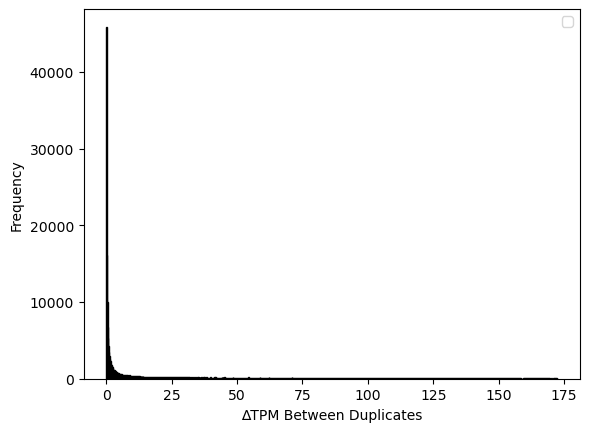

In [73]:
plt.hist(diffs_flattened_filtered, bins=1000, edgecolor='black')

line_num = 200

# plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))

plt.xlabel('∆TPM Between Duplicates')
plt.ylabel('Frequency')
plt.title(f'')

plt.legend()

plt.show()

In [74]:
tpms_diff_filtered_flattened = df_diff_filtered[tpm_cols].to_numpy().flatten()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


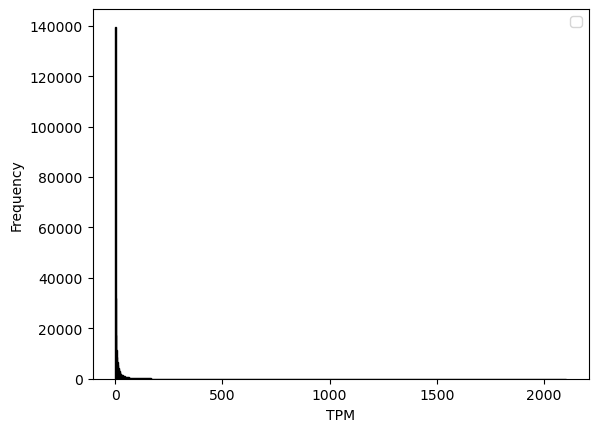

In [75]:
plt.hist(tpms_diff_filtered_flattened, bins=1000, edgecolor='black')

line_num = 200

# plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))

plt.xlabel('TPM')
plt.ylabel('Frequency')
plt.title(f'')

plt.legend()

plt.show()

In [76]:
max(tpms_diff_filtered_flattened)

2102.71

In [77]:
max(tpms_flattened) 

56844.4

Highly expressed genes filtered out when high quantile max ∆TPMs are filtered out

# Export the filtered TPM data to CSV

In [78]:
df_filtered.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,210min_diff,240min_diff,percent_diff_000min_A_210min_A,percent_diff_000min_B_210min_B,percent_diff_000min_diff_210min_diff,percent_diff_030min_A_240min_A,percent_diff_030min_B_240min_B,percent_diff_030min_diff_240min_diff,max_tpm,max_diff
0,YF00000001.t1,0.586688,1.67666,0.941571,1.43078,0.39673,1.37467,0.642154,1.55882,1.16155,...,0.855023,0.531225,80.351462,41.066544,24.159342,65.906145,34.859223,8.234927,1.93705,80.351462
1,YF00000003.t1,30.365900,32.45480,43.555100,29.39020,48.14460,30.63640,59.071300,31.16230,52.88810,...,2.677500,5.853100,41.279034,40.306841,24.697885,18.134331,35.709355,83.043261,59.07130,83.043261
2,YF00000004.t1,1.151560,2.62859,24.640100,26.66560,43.23010,19.20550,40.661300,25.40090,24.48950,...,6.256650,0.692900,156.666770,142.743128,123.605321,55.915955,67.690624,98.042966,43.23010,156.666770
3,YF00000005.t1,33.436500,96.28970,60.380000,99.78100,66.93020,104.45600,63.086300,97.37460,59.34830,...,11.856900,16.911000,49.764446,35.234035,136.517820,21.996720,41.737449,79.876403,124.78900,136.517820
4,YF00000006.t1,16.980400,10.33890,14.464300,14.76590,24.43420,14.55810,24.204800,14.89720,23.90960,...,2.065200,1.332200,31.513564,69.153107,105.121343,26.876962,31.504415,126.159873,25.72720,126.159873


In [79]:
df_filtered[df_filtered.columns[1:]].max(axis=None)

56844.4

In [80]:
df_filtered.to_csv('./tpm_kallisto.csv', index=False)

bottom 5% and one dup 0 prob true 0
above bottom 5% and one dup 0, something went wrong?

should we remove the last two timepoints in order to not give more weight to G1 phase in clustering?

# Take the geometric mean of each set of timepoint duplicates

In [81]:
def geo_mean_df_of_duplicates(df: pd.DataFrame):
    return_df = df.loc[:, df.columns[0:1]]
    num_df = df.loc[:, df.columns[1:]]

    idxa = 0
    idxb = 1

    num_df_cols = list(num_df.columns)

    while idxb < len(num_df_cols):
        col_a_split = num_df_cols[idxa].split('_')
        col_name = '_'.join(col_a_split[:len(col_a_split)-1])
        return_df[col_name] = np.sqrt(np.where((num_df[num_df_cols[idxa]] == 0) | (num_df[num_df_cols[idxb]] == 0), 0, num_df[num_df_cols[idxa]] * num_df[num_df_cols[idxb]]))

        idxa += 1
        idxb += 1
    
    return return_df

In [82]:
df_all_tpms_averaged = geo_mean_df_of_duplicates(df_all_tpm.loc[:, all_cols])
df_all_tpms_averaged

,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
0,YF00000001.t1,1.256461,0.753414,0.939548,1.345603,1.022637,1.021710,0.696428,0.724483,0.691157
1,YF00000003.t1,37.597501,37.616212,42.540945,40.596981,42.575327,43.098935,44.722498,42.112618,39.130565
2,YF00000004.t1,8.047902,33.952269,27.944957,24.941037,19.089894,14.321346,12.531916,14.774490,13.521812
3,YF00000005.t1,76.249407,81.721247,81.177229,76.019846,75.501193,83.100607,70.496820,57.142715,56.237799
4,YF00000006.t1,12.228857,18.994551,18.771678,18.872893,20.536830,19.865220,21.244316,20.078055,19.610191
...,...,...,...,...,...,...,...,...,...,...
25982,YF00038376.t1,0.940133,1.407921,1.542528,1.275465,1.011045,0.740933,0.911942,0.969431,0.947862
25983,YF00038377.t1,0.129766,0.036646,0.030387,0.044673,0.042410,0.053397,0.060143,0.050815,0.047485
25984,YF00038378.t1,4.221523,3.606703,3.521457,3.489134,4.087515,4.829793,3.484258,3.042917,2.785708
25985,YF00038707.t1,0.430747,0.059011,0.053490,0.056918,0.139824,0.158857,0.135369,0.106722,0.116170


In [83]:
df_filtered_averaged = geo_mean_df_of_duplicates(df_filtered.loc[:, all_cols])
df_filtered_averaged.head()

,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
0,YF00000001.t1,1.256461,0.753414,0.939548,1.345603,1.022637,1.021710,0.696428,0.724483,0.691157
1,YF00000003.t1,37.597501,37.616212,42.540945,40.596981,42.575327,43.098935,44.722498,42.112618,39.130565
2,YF00000004.t1,8.047902,33.952269,27.944957,24.941037,19.089894,14.321346,12.531916,14.774490,13.521812
3,YF00000005.t1,76.249407,81.721247,81.177229,76.019846,75.501193,83.100607,70.496820,57.142715,56.237799
4,YF00000006.t1,12.228857,18.994551,18.771678,18.872893,20.536830,19.865220,21.244316,20.078055,19.610191


In [84]:
df_filtered_more_averaged = geo_mean_df_of_duplicates(df_filtered_more.loc[:, all_cols])
df_filtered_more_averaged.head()

,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
0,YF00000001.t1,1.256461,0.753414,0.939548,1.345603,1.022637,1.021710,0.696428,0.724483,0.691157
1,YF00000003.t1,37.597501,37.616212,42.540945,40.596981,42.575327,43.098935,44.722498,42.112618,39.130565
2,YF00000004.t1,8.047902,33.952269,27.944957,24.941037,19.089894,14.321346,12.531916,14.774490,13.521812
3,YF00000005.t1,76.249407,81.721247,81.177229,76.019846,75.501193,83.100607,70.496820,57.142715,56.237799
4,YF00000006.t1,12.228857,18.994551,18.771678,18.872893,20.536830,19.865220,21.244316,20.078055,19.610191


In [85]:
df_filtered_less_averaged = geo_mean_df_of_duplicates(df_filtered_less.loc[:, all_cols])
df_filtered_less_averaged.head()

,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
0,YF00000001.t1,1.256461,0.753414,0.939548,1.345603,1.022637,1.021710,0.696428,0.724483,0.691157
1,YF00000003.t1,37.597501,37.616212,42.540945,40.596981,42.575327,43.098935,44.722498,42.112618,39.130565
2,YF00000004.t1,8.047902,33.952269,27.944957,24.941037,19.089894,14.321346,12.531916,14.774490,13.521812
3,YF00000005.t1,76.249407,81.721247,81.177229,76.019846,75.501193,83.100607,70.496820,57.142715,56.237799
4,YF00000006.t1,12.228857,18.994551,18.771678,18.872893,20.536830,19.865220,21.244316,20.078055,19.610191


In [86]:
df_filtered.loc[:, all_cols].head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,YF00000001.t1,0.586688,1.67666,0.941571,1.43078,0.39673,1.37467,0.642154,1.55882,1.16155,1.87789,0.556894,1.46126,0.714378,1.93705,0.250387,1.10541,0.474825,1.00605
1,YF00000003.t1,30.365900,32.45480,43.555100,29.39020,48.14460,30.63640,59.071300,31.16230,52.88810,38.39890,47.206000,36.22920,51.271300,43.32920,46.160600,48.83810,36.313300,42.16640
2,YF00000004.t1,1.151560,2.62859,24.640100,26.66560,43.23010,19.20550,40.661300,25.40090,24.48950,24.96380,14.598100,18.05180,11.361800,16.56940,9.478250,15.73490,13.872700,13.17980
3,YF00000005.t1,33.436500,96.28970,60.380000,99.78100,66.93020,104.45600,63.086300,97.37460,59.34830,106.06300,53.745700,124.78900,55.339100,89.40470,55.587700,67.44460,48.414400,65.32540
4,YF00000006.t1,16.980400,10.33890,14.464300,14.76590,24.43420,14.55810,24.204800,14.89720,23.90960,17.97100,23.469000,15.33890,25.727200,19.34310,23.332400,21.26720,18.955400,20.28760


# Filter out genes with all zeros

In [87]:
avg_cols = list(df_all_tpms_averaged.columns)
len_avg_cols = len(avg_cols)
avg_cols_final = avg_cols[:len_avg_cols-2]
avg_cols_final

['TTHERM_ID',
 '000min',
 '030min',
 '060min',
 '090min',
 '120min',
 '150min',
 '180min']

In [88]:
df_all_tpms_averaged_final = df_all_tpms_averaged.loc[:, avg_cols_final]
df_all_tpms_averaged_final.head()

,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min
0,YF00000001.t1,1.256461,0.753414,0.939548,1.345603,1.022637,1.021710,0.696428
1,YF00000003.t1,37.597501,37.616212,42.540945,40.596981,42.575327,43.098935,44.722498
2,YF00000004.t1,8.047902,33.952269,27.944957,24.941037,19.089894,14.321346,12.531916
3,YF00000005.t1,76.249407,81.721247,81.177229,76.019846,75.501193,83.100607,70.496820
4,YF00000006.t1,12.228857,18.994551,18.771678,18.872893,20.536830,19.865220,21.244316


In [89]:
df_all_tpms_averaged_zeros = df_all_tpms_averaged_final[(df_all_tpms_averaged_final.iloc[:, 1:] == 0.0).all(axis=1)]

print(df_all_tpms_averaged_zeros.shape)

df_all_tpms_averaged_zeros.head()

(2866, 8)


,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min
15,YF00000019.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,YF00000043.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68,YF00000081.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,YF00000082.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,YF00000084.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
df_all_tpms_averaged_filtered = df_all_tpms_averaged_final[~df_all_tpms_averaged_final.isin(df_all_tpms_averaged_zeros)].dropna()
df_all_tpms_averaged_filtered.reset_index()
print(df_all_tpms_averaged_final.shape[0])
print(df_all_tpms_averaged_filtered.shape[0])
print(df_all_tpms_averaged_final.shape[0]-df_all_tpms_averaged_filtered.shape[0])
df_all_tpms_averaged_filtered.head()

25987
23121
2866


,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min
0,YF00000001.t1,1.256461,0.753414,0.939548,1.345603,1.022637,1.021710,0.696428
1,YF00000003.t1,37.597501,37.616212,42.540945,40.596981,42.575327,43.098935,44.722498
2,YF00000004.t1,8.047902,33.952269,27.944957,24.941037,19.089894,14.321346,12.531916
3,YF00000005.t1,76.249407,81.721247,81.177229,76.019846,75.501193,83.100607,70.496820
4,YF00000006.t1,12.228857,18.994551,18.771678,18.872893,20.536830,19.865220,21.244316


In [91]:
df_filtered_averaged_with_all_zeros = df_filtered_averaged[(df_filtered_averaged.iloc[:, 1:] == 0.0).all(axis=1)]

print(df_filtered_averaged_with_all_zeros.shape)

df_filtered_averaged_with_all_zeros.head()

(1365, 10)


,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
33,YF00000043.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68,YF00000081.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139,YF00000165.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147,YF00000175.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
169,YF00000208.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
df_filtered_more_averaged_with_all_zeros = df_filtered_more_averaged[(df_filtered_more_averaged.iloc[:, 1:] == 0.0).all(axis=1)]

print(df_filtered_more_averaged_with_all_zeros.shape)

df_filtered_more_averaged_with_all_zeros.head()

(1015, 10)


,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
33,YF00000043.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68,YF00000081.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139,YF00000165.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147,YF00000175.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
169,YF00000208.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
df_filtered_less_averaged_with_all_zeros = df_filtered_less_averaged[(df_filtered_less_averaged.iloc[:, 1:] == 0.0).all(axis=1)]

print(df_filtered_less_averaged_with_all_zeros.shape)

df_filtered_less_averaged_with_all_zeros.head()

(1013, 10)


,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
33,YF00000043.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68,YF00000081.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147,YF00000175.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
169,YF00000208.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170,YF00000209.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
df_filtered_averaged_no_all_zeros = df_filtered_averaged[~df_filtered_averaged.isin(df_filtered_averaged_with_all_zeros)].dropna()
df_filtered_averaged_no_all_zeros.reset_index()
print(df_filtered_averaged.shape[0])
print(df_filtered_averaged_no_all_zeros.shape[0])
print(df_filtered_averaged.shape[0]-df_filtered_averaged_no_all_zeros.shape[0])
df_filtered_averaged_no_all_zeros.head()

24542
23177
1365


,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
0,YF00000001.t1,1.256461,0.753414,0.939548,1.345603,1.022637,1.021710,0.696428,0.724483,0.691157
1,YF00000003.t1,37.597501,37.616212,42.540945,40.596981,42.575327,43.098935,44.722498,42.112618,39.130565
2,YF00000004.t1,8.047902,33.952269,27.944957,24.941037,19.089894,14.321346,12.531916,14.774490,13.521812
3,YF00000005.t1,76.249407,81.721247,81.177229,76.019846,75.501193,83.100607,70.496820,57.142715,56.237799
4,YF00000006.t1,12.228857,18.994551,18.771678,18.872893,20.536830,19.865220,21.244316,20.078055,19.610191


In [95]:
df_filtered_more_averaged_no_all_zeros = df_filtered_more_averaged[~df_filtered_more_averaged.isin(df_filtered_more_averaged_with_all_zeros)].dropna()
df_filtered_more_averaged_no_all_zeros.reset_index()
print(df_filtered_more_averaged.shape[0])
print(df_filtered_more_averaged_no_all_zeros.shape[0])
print(df_filtered_more_averaged.shape[0]-df_filtered_more_averaged_no_all_zeros.shape[0])
df_filtered_more_averaged_no_all_zeros.head()

23781
22766
1015


,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
0,YF00000001.t1,1.256461,0.753414,0.939548,1.345603,1.022637,1.021710,0.696428,0.724483,0.691157
1,YF00000003.t1,37.597501,37.616212,42.540945,40.596981,42.575327,43.098935,44.722498,42.112618,39.130565
2,YF00000004.t1,8.047902,33.952269,27.944957,24.941037,19.089894,14.321346,12.531916,14.774490,13.521812
3,YF00000005.t1,76.249407,81.721247,81.177229,76.019846,75.501193,83.100607,70.496820,57.142715,56.237799
4,YF00000006.t1,12.228857,18.994551,18.771678,18.872893,20.536830,19.865220,21.244316,20.078055,19.610191


In [96]:
df_filtered_less_averaged_no_all_zeros = df_filtered_less_averaged[~df_filtered_less_averaged.isin(df_filtered_less_averaged_with_all_zeros)].dropna()
df_filtered_less_averaged_no_all_zeros.reset_index()
print(df_filtered_less_averaged.shape[0])
print(df_filtered_less_averaged_no_all_zeros.shape[0])
print(df_filtered_less_averaged.shape[0]-df_filtered_less_averaged_no_all_zeros.shape[0])
df_filtered_less_averaged_no_all_zeros.head()

24648
23635
1013


,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
0,YF00000001.t1,1.256461,0.753414,0.939548,1.345603,1.022637,1.021710,0.696428,0.724483,0.691157
1,YF00000003.t1,37.597501,37.616212,42.540945,40.596981,42.575327,43.098935,44.722498,42.112618,39.130565
2,YF00000004.t1,8.047902,33.952269,27.944957,24.941037,19.089894,14.321346,12.531916,14.774490,13.521812
3,YF00000005.t1,76.249407,81.721247,81.177229,76.019846,75.501193,83.100607,70.496820,57.142715,56.237799
4,YF00000006.t1,12.228857,18.994551,18.771678,18.872893,20.536830,19.865220,21.244316,20.078055,19.610191


# Normalize expression per gene with zscore

In [97]:
def normalizer(array):
    log_a = [np.log10(tpm + 1) for tpm in array]
    normalized = st.zscore(log_a)
    return normalized

def normalize_expression_per_gene(expression_df):
    if 'TTHERM_ID' in expression_df.columns:
        ttids = expression_df['TTHERM_ID'].values
        data = expression_df[list(expression_df.columns)[1:]]
        
        norm_expression_df = pd.DataFrame(data.apply(normalizer, axis=1).tolist(), columns=data.columns)

        norm_expression_df['TTHERM_ID'] = ttids

        columns = norm_expression_df.columns.tolist()

        rearrangement = columns[-1:] + columns[:-1]

        norm_expression_df = norm_expression_df[rearrangement]
    else:
        norm_expression_df = pd.DataFrame(expression_df.apply(normalizer, axis=1).tolist(), columns=expression_df.columns)

    return norm_expression_df


In [98]:
normalized_tpm_df = normalize_expression_per_gene(df_all_tpms_averaged_filtered)
normalized_tpm_df.head()

,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min
0,YF00000001.t1,1.123899,-1.158704,-0.245693,1.474524,0.133912,0.129766,-1.457703
1,YF00000003.t1,-1.441383,-1.433493,0.520480,-0.223054,0.533330,0.727776,1.316344
2,YF00000004.t1,-1.716422,1.350448,0.922483,0.673835,0.093776,-0.521140,-0.802980
3,YF00000005.t1,-0.338036,0.955871,0.831122,-0.394303,-0.522050,1.268533,-1.801136
4,YF00000006.t1,-2.369502,0.182542,0.113287,0.144834,0.641626,0.445889,0.841324


Sanity check

In [99]:
row_to_check = normalized_tpm_df.loc[2, normalized_tpm_df.columns[1:]] 

row_mean = np.mean(row_to_check)
row_std = np.std(row_to_check)

print(row_mean)
print(row_std)

-2.5376526277146434e-16
1.0


In [100]:
normalized_tpm_df.shape

(23121, 8)

In [101]:
normalized_tpm_df.to_csv('./kallisto.csv', index=False)